Torch implementation of NMF - When done should be moved to a .py file to allow easy implementation, or alternatively allow saving of model parameters

In [6]:
import torch
import numpy as np
import pandas as pd

from helpers.data import X
from helpers.callbacks import earlyStop
from helpers.losses import frobeniusLoss

Non negative matrix factorization works by finding matrices A and B such that X = AB

In [2]:
class torchNMF(torch.nn.Module):
    def __init__(self, X, rank):
        super(torchNMF, self).__init__()
        
        #Shape of Matrix for reproduction
        n_row, n_col = X.shape
        self.X = torch.tensor(X)
        
        self.softplus = torch.nn.Softplus()
        
        #Initialization of Tensors/Matrices a and b with size NxR and RxM
        self.A = torch.nn.Parameter(torch.rand(n_row, rank, requires_grad=True))
        self.B = torch.nn.Parameter(torch.rand(rank, n_col, requires_grad=True))
        
    def forward(self):
        
        #Implementation of NMF - F(A, B) = ||X - AB||^2
        self.AB = torch.matmul(self.softplus(self.A),
                               self.softplus(self.B))
        x = self.X - self.AB
        
        return x

In [18]:
torch.manual_seed(0)

nmf = torchNMF(X, 3)

#optimizer for modifying learning rate, ADAM chosen because of https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = torch.optim.Adam(nmf.parameters(), lr=0.3)

#early stopping
es = earlyStop(patience=5, offset=-0.1)

running_loss = []

while (not es.trigger()):
    #zero optimizer gradient
    optimizer.zero_grad()

    #forward
    output = nmf()
    
    #backward
    loss = frobeniusLoss()
    loss = loss.forward(output)
    loss.backward()
    
    #Update A and B
    optimizer.step()
    
    running_loss.append(loss.item())
    es.count(loss.item())
    
    #print loss
    print(f"epoch: {len(running_loss)}, Loss: {loss.item()}", end='\r')

In [17]:
A, B = list(nmf.parameters())

A = nmf.softplus(A)
B = nmf.softplus(B)

A = A.detach().numpy()
B = B.detach().numpy()

rec = np.dot(A, B)

rec = rec.T

rec_frame = pd.DataFrame(rec)
rec_frame.columns = rec_frame.columns.astype(str)


rec_frame.to_parquet("recons_x_nmf.parquet",
                     engine = 'fastparquet')

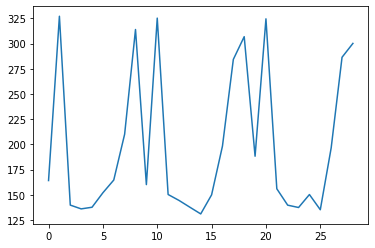

In [12]:
import matplotlib.pyplot as plt

plt.plot(rec[0])
plt.show()